# Tres en raya

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random 
import numpy as np

In [3]:
batch_size = 50

In [11]:
def print_board(board):
    symbols = ['O', ' ', 'X']
    board_plus_1 = [int(x)+1 for x in board]
    board_line_1 = '{}|{}|{}'.format(symbols[board_plus_1[0]], symbols[board_plus_1[1]], symbols[board_plus_1[2]])
    board_line_2 = '{}|{}|{}'.format(symbols[board_plus_1[3]], symbols[board_plus_1[4]], symbols[board_plus_1[5]])
    board_line_3 = '{}|{}|{}'.format(symbols[board_plus_1[6]], symbols[board_plus_1[7]], symbols[board_plus_1[8]])
    print(board_line_1)
    print('_____')
    print(board_line_2)
    print('_____')
    print(board_line_3)

In [12]:
print_board([-1,0,0,1,1,0,0,-1,1])

O| | 
_____
X|X| 
_____
 |O|X


In [19]:
def get_symmetry(board, response, transformation):
    '''
    :param board: lista de 9 enteros formados por:
    - O = -1, símbolo del enemigo
    - X =  1, símbolo del jugador
    - ' ' = 0, casilla vacía
    :param transformation: ona de las cinco transformaciones del tablero:
    - rotate90, rotate180, rotate270, flip_v, flip_h
    :return: tuple(new_board, new_response)
    '''
    
    if transformation == 'rotate180':
        new_response = 8-response
        return board[::-1], new_response
    
    elif transformation == 'rotate90':
        new_reponse = [6,3,0,7,4,1,8,5,2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return [value for item in tuple_board for value in item], new_reponse
    
    elif transformation == 'rotate270':
        new_reponse = [2,5,8,1,4,7,0,3,6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return [value for item in tuple_board for value in item], new_reponse
    
    elif transformation == 'flip_v':
        new_response = [6,7,8,3,4,5,0,1,2].index(response)
        return board[6:9]+board[3:6]+board[0:3], new_response
    
    elif transformation == 'flip_h':
        new_response = [2,1,0,5,4,3,8,7,6].index(response)
        new_board = board[::-1]
        return new_board[6:9]+new_board[3:6]+new_board[0:3], new_response
    
    else:
        raise ValueError('Este movimiento no está contemplado')

In [21]:
print_board(get_symmetry([-1,0,0,1,1,0,0,-1,1], 1, 'flip_h')[0])

 | |O
_____
 |X|X
_____
X|O| 


In [24]:
def get_moves_from_csv(csv_file):
    '''
    :param csv_file: Fichero CSV con las respuestas para cada configuración esencial de tablero
    :return moves: lista de los mejores movimientos posibles del tablero
    '''
    moves = []
    with open(csv_file,'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter =',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return moves

In [26]:
moves = get_moves_from_csv("../../datasets/moves_tic_tac_toe.csv")

In [29]:
def get_random_move(moves, rand_transforms = 2):
    (board, response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, response) = get_symmetry(board, response, random_transform)
    return board, response

In [36]:
get_random_move(moves, 2)

([0, -1, 1, 0, 0, -1, -1, 1, 0], 3)

### Enseñar a jugar al tres en raya a TensorFlow

In [37]:
session = tf.Session()

In [38]:
train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_random_move(moves))

In [39]:
train_set[0]

([0, -1, 1, 0, 0, 0, -1, 0, 0], 4)

In [40]:
test_board = [-1,0,0,1,-1,-1,0,0,1] # -> 6

In [45]:
print_board(test_board)

O| | 
_____
X|O|O
_____
 | |X


In [ ]:
train_set = [x for x in train_set if x[0]!=test_board]

In [46]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape))

In [49]:
def model(X, A1, A2, b1, b2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X,A1),b1))
    layer2 = tf.add(tf.matmul(layer1, A2),b2)
    return layer2

In [50]:
X = tf.placeholder(dtype=tf.float32, shape=[None,9])
Y = tf.placeholder(dtype=tf.int32, shape=[None])
A1 = init_weights([9, 81])
b1 = init_weights([81])
A2 = init_weights([81,9])
b2 = init_weights([9])
model_output = model(X, A1, A2, b1, b2)

In [52]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels = Y))
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
prediction = tf.argmax(model_output,1)

In [53]:
init = tf.global_variables_initializer()
session.run(init)

In [54]:
loss_vect = []
for i in range(10000):
    rand_idx = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data = [train_set[i] for i in rand_idx]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    session.run(train_step, feed_dict={X:x_input, Y:y_target})
    temp_loss = session.run(loss, feed_dict={X:x_input, Y:y_target})
    loss_vect.append(temp_loss)
    if(i+1)%500==0:
        print("Step #"+str(i+1)+", Loss: "+str(temp_loss))

Step #500, Loss: 1.9701289
Step #1000, Loss: 1.4345028
Step #1500, Loss: 1.730488
Step #2000, Loss: 1.3299835
Step #2500, Loss: 1.3530618
Step #3000, Loss: 1.3591133
Step #3500, Loss: 1.5120759
Step #4000, Loss: 1.2053111
Step #4500, Loss: 1.3036326
Step #5000, Loss: 0.88818204
Step #5500, Loss: 0.88741493
Step #6000, Loss: 1.186519
Step #6500, Loss: 1.0896116
Step #7000, Loss: 1.031956
Step #7500, Loss: 1.0437403
Step #8000, Loss: 0.90897256
Step #8500, Loss: 0.8668886
Step #9000, Loss: 0.91722643
Step #9500, Loss: 0.9557369
Step #10000, Loss: 0.64047205


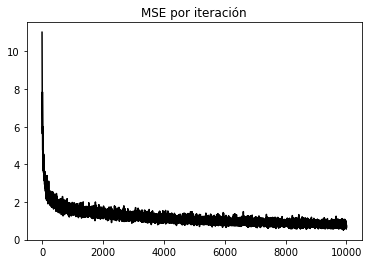

In [55]:
plt.plot(loss_vect, 'k-', label = "Función de pérdidas")
plt.title("MSE por iteración")
plt.show()

## Comprobando el modelo entrenado

In [56]:
test_boards = [test_board]
feed_dict = {X:test_boards}
logits = session.run(model_output, feed_dict=feed_dict)
predictions = session.run(prediction, feed_dict=feed_dict)

In [57]:
print(predictions)

[6]


In [58]:
def check(board):
    wins = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8], [0,4,8], [2,4,6]]
    for i in range(len(wins)):
        if board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==1.0:
            return 1
        elif board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==-1.0:
            return 1
    return 0

In [62]:
game_tracker = [0,0,0,0,0,0,0,0,0]
win_logical = False
num_moves = 0
while not win_logical:
    player_idx = input('Introduce tu posición de juego (0-8): ')
    num_moves +=1
    game_tracker[int(player_idx)] = 1.0
    
    [potential_moves] = session.run(model_output, feed_dict={X:[game_tracker]})
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x==0]
    model_move = np.argmax([x if ix in allowed_moves else -9999 for ix, x in enumerate(potential_moves)])
    game_tracker[int(model_move)] = -1.0
    
    print("El modelo ha movido:")
    print_board(game_tracker)
    if check(game_tracker)==1 or num_moves>=5:
        print("Game Over")
        win_logical = True

Introduce tu posición de juego (0-8): 4
El modelo ha movido:
 | | 
_____
 |X| 
_____
 | |O
Introduce tu posición de juego (0-8): 0
El modelo ha movido:
X| | 
_____
 |X| 
_____
O| |O
Introduce tu posición de juego (0-8): 3
El modelo ha movido:
X| |O
_____
X|X| 
_____
O| |O
Introduce tu posición de juego (0-8): 1
El modelo ha movido:
X|X|O
_____
X|X| 
_____
O|O|O
Game Over
